In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import statsmodels.api as sm
import scipy as sp
import itertools
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
MyColors = ["#0078D7", "#E74856", "#FFB900", "#10893E", "#B146C2",
"#00B7C3", "#E3008C", "#FF8C00", "#00CC6A", "#6B69D6",
"#0099BC", "#C30052", "#F7630C", "#00B294", "#8764B8"]
sns.set_palette(MyColors)

In [79]:
# Read discount factor data
df_init = pd.read_excel(r"C:\Users\yahsk\Desktop\Q2\Fixed income markets\ALL HW AND SOLUTIONS except 8\Homework_export 7\Homework 7\Homework_7_Data.xlsx", sheet_name=2,header=None)[0]

# Create an array of length equal to df_init length, starting from 0.5 with step 0.5
new_index = np.arange(0.5, 0.5*(len(df_init)+1), 0.5)

# Assign the new index
df_init.index = new_index

# Truncate to the first 10 elements
df_init = df_init[:10]
df_init

0.5     0.972476
1.0     0.944569
1.5     0.916324
2.0     0.887934
2.5     0.859741
3.0     0.832044
3.5     0.805077
4.0     0.778904
4.5     0.753480
5.0     0.728734
5.5     0.704580
6.0     0.681010
6.5     0.658042
7.0     0.635692
7.5     0.613977
8.0     0.592905
8.5     0.572482
9.0     0.552713
9.5     0.533601
10.0    0.515148
Name: 0, dtype: float64

In [80]:
# Read volatility data
vol = pd.read_excel(r"C:\Users\yahsk\Desktop\Q2\Fixed income markets\ALL HW AND SOLUTIONS except 8\Homework_export 7\Homework 7\Homework_7_Data.xlsx", sheet_name=3, header=None)[0]

# Create an array of length equal to vol length, starting from 0.5 with step 0.5
new_index = np.arange(0.5, 0.5 + 0.5*len(vol), 0.5)

# Assign the new index
vol.index = new_index

# Replace the first entry with 0
vol.loc[0.5] = 0

# Sort the index
vol = vol.sort_index()

# Truncate to the first 20 elements
vol = vol[:10]
vol

0.5     0.0000
1.0     0.0040
1.5     0.0090
2.0     0.0160
2.5     0.0225
3.0     0.0258
3.5     0.0287
4.0     0.0320
4.5     0.0342
5.0     0.0360
5.5     0.0385
6.0     0.0408
6.5     0.0429
7.0     0.0448
7.5     0.0450
8.0     0.0464
8.5     0.0476
9.0     0.0486
9.5     0.0494
10.0    0.0500
Name: 0, dtype: float64

In [61]:
# Read cholesky matrix
mat_chol = pd.read_excel(r"C:\Users\yahsk\Desktop\Q2\Fixed income markets\ALL HW AND SOLUTIONS except 8\Homework_export 7\Homework 7\Homework_7_Data.xlsx", sheet_name=1, header=None).values


In [81]:
# Function to compute short rate based on string model
def string(df, vol, mat_chol, seed):
    # Generate dz
    np.random.seed(seed)
    dz = pd.DataFrame(mat_chol @ np.random.normal(size=[20, 20]),
        index=np.arange(0.5, 10+0.5, 0.5),
        columns=np.arange(0.5, 10+0.5, 0.5))
    # Repeatedly compute short rate & DF curve t=0.5 to 9.5
    # Note: index: maturity, columns: time
    B = pd.DataFrame(None,
        index=np.arange(0.5, 10+0.5, 0.5),
        columns=np.arange(0, 10+0.5, 0.5))
    r_save = pd.Series(index=np.arange(0, 9.5+0.5, 0.5))
    # Repeat process
    B[0] = df
    vol_t = vol.copy()
    for t in np.arange(0.5, 10+0.5, 0.5):
        r = (1/B[t-0.5][t]-1)*2
        B[t] = B[t-0.5]+r*B[t-0.5]/2 + vol_t*B[t-0.5]*dz[t]
        vol_t = vol_t.shift()
        r_save[t-0.5] = r
    return r_save

In [82]:
# Monte Carlo simulation: String model
r_sim = pd.DataFrame({n: string(df_init, vol, mat_chol, n)
for n in range(0, 10000)})

In [83]:
#Compute discount factor path
df_sim = (1/(1+r_sim/2)).cumprod()
df_sim.index = np.arange(0.5, 10+0.5, 0.5)

In [84]:
r_sim.T[0:6].T

,0,1,2,3,4,5
0.0,0.056605,0.056605,0.056605,0.056605,0.056605,0.056605
0.5,0.049336,0.048141,0.063765,0.046998,0.060252,0.057183
1.0,0.051794,0.053535,0.067890,0.048795,0.062417,0.065089
1.5,0.049352,0.055121,0.093942,0.030423,0.055480,0.049890
2.0,0.037424,0.066494,0.080300,0.059990,0.087258,0.028619
2.5,0.015663,0.056148,0.086952,0.068709,0.062958,0.034451
3.0,0.017128,0.070226,0.098752,0.104286,0.071926,0.019181
3.5,0.003777,0.044258,0.107565,0.090463,0.113931,0.004256
4.0,0.006622,0.078030,0.104170,0.093355,0.109047,0.039303
4.5,0.116241,0.046086,0.053417,0.103915,0.093066,0.070304


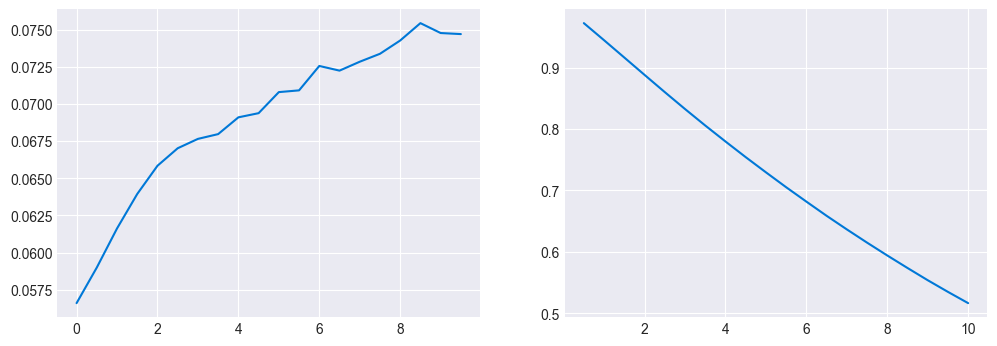

In [66]:
# Plot average short rate curve and DF curve
fig, ax = plt.subplots(1, 2, figsize=(6*2, 4))
r_sim.T.mean().plot(ax=ax[0])
df_sim.T.mean().plot(ax=ax[1]);

In [67]:
# Compute forward par rate based on the simulated path
fwd_par_sim = pd.DataFrame({
m: 2*(df_sim.loc[5,:]-df_sim.loc[5+m,:])/df_sim[(5+0.5):(5+m)].sum()
for m in range(1, 5+1)
})

In [68]:
# Compute the expected value of forward par rate
fwd_par = fwd_par_sim.mean()
fwd_par

1    0.070688
2    0.071252
3    0.071589
4    0.072083
5    0.072311
dtype: float64

In [69]:
# Reference: Compute the forward par rate based on the initial curve
fwd_par_init = pd.Series({
m: 2*(df_init[5]-df_init[5+m])/df_init[(5+0.5):(5+m)].sum()
for m in range(1, 5+1)
})
fwd_par_init

1    0.068886
2    0.069452
3    0.069903
4    0.070248
5    0.070489
dtype: float64

In [70]:
# Compute par rate based on the simulated path
par_sim = pd.DataFrame({
m: 2*(1-df_sim.loc[m,:])/df_sim[0.5:m].sum()
for m in [2,3,5,10]
})

In [71]:
par = par_sim.mean()
par

2     0.060151
3     0.062019
5     0.064174
10    0.067321
dtype: float64

In [72]:
def calc_cap(K, r_sim, df_sim):
    cf_sim = (r_sim-K)*0.5
    cf_sim = cf_sim.mask(cf_sim<0,0)
    cf_sim.index = df_sim.index
    pv = (cf_sim*df_sim).sum().mean()
    return pv

In [73]:
pv_cap = par.apply(lambda x: calc_cap(x, r_sim, df_sim))
pv_cap

2     0.129223
3     0.122290
5     0.114719
10    0.104442
dtype: float64

In [74]:
def calc_reset_cap(m, r_sim, df_sim):
    cf = 0.5*r_sim.diff()
    cf.index = df_sim.index
    pv = (cf.mask(cf<0,0)*df_sim).loc[:m].sum().mean()
    return pv

In [75]:
calc_reset_cap(5, r_sim, df_sim)

0.034378812589172275

In [76]:
m = 5
cms_sim = pd.DataFrame({
    t: 2*(df_sim.loc[t,:]-df_sim.loc[t+m,:])/df_sim[(t+0.5):(t+m)].sum()
    for t in np.arange(0.5, 5+0.5, 0.5)}).T

In [77]:
cms_sim.loc[:,0:4]

,0,1,2,3,4
0.5,0.038733,0.058599,0.084097,0.069605,0.077559
1.0,0.041587,0.053870,0.084890,0.075490,0.077625
1.5,0.043233,0.057802,0.090110,0.067892,0.078745
2.0,0.046732,0.057979,0.093348,0.069558,0.078169
2.5,0.041305,0.059409,0.097222,0.061923,0.071013
3.0,0.047221,0.059002,0.100133,0.063023,0.060615
3.5,0.054896,0.055413,0.094870,0.053373,0.052369
4.0,0.065821,0.055312,0.085024,0.052297,0.046386
4.5,0.071520,0.056464,0.079349,0.048212,0.037028
5.0,0.076780,0.064378,0.071664,0.057736,0.043252


In [78]:
cf_sim = cms_sim-0.05
cf_sim = 0.5*cf_sim.mask(cf_sim<0,0)
pv = (cf_sim*df_sim[:5]).sum().mean()
pv

0.09018871704821833